# MicroB Prediction

__TRIN DATA FEATURES__


row_id,cfips,county,state,first_day_of_month
pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021
pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,pct_college_2021
pct_foreign_born_2017,pct_foreign_born_2018,pct_foreign_born_2019,pct_foreign_born_2020,pct_foreign_born_2021
pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021
median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021

__FROM EXTERNAL__
Total!!Estimate!!Population 18 to 24 years!!Less than high school graduate!
Total!!Estimate!!Population 18 to 24 years!!High school graduate (includes equivalency)!
Total!!Estimate!!Population 18 to 24 years!!Some college or associate's degree!
Total!!Estimate!!Population 18 to 24 years!!Bachelor's degree or higher!

Total!!Estimate!!Population 25 years and over!!9th to 12th grade, no diploma!
Total!!Estimate!!Population 25 years and over!!High school graduate (includes equivalency)
Total!!Margin of Error!!Population 25 years and over!!Some college, no degree!2.png)
Total!!Estimate!!Population 25 years and over!!Associate's degree!
Total!!Estimate!!Population 25 years and over!!Bachelor's degree!
Total!!Estimate!!Population 25 years and over!!Graduate or professional degree!

__PREDICT__
microbusiness_density

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

# Data


In [258]:
df_train = pd.read_csv('/Users/joheunkang/microb/data/train.csv')
df_test = pd.read_csv('/Users/joheunkang/microb/data/test.csv')
df_census = pd.read_csv('/Users/joheunkang/microb/data/census_starter.csv')
df_s_a_edu21 = pd.read_csv('/Users/joheunkang/microb/data/external/state_a_2017_edu/ACSST1Y2017.S1501-Data.csv')


In [337]:
# Covid data 
# data souce : https://github.com/nytimes/covid-19-data
covid_20 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2020.csv")
covid_21 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2021.csv")
covid_22 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2022.csv")
covid_23 = pd.read_csv("/Users/joheunkang/microb/data/us-counties-2023.csv")
covid_recent = pd.read_csv("/Users/joheunkang/microb/data/us-counties-recent.csv")

# make class 

In [332]:
class Microb:
  def __init__(self,df,df_1):
    self.df = df  
    self.df1 = df_1

  def change_to_datetime(self):
    self.df['first_day_of_month'] = pd.to_datetime(self.df['first_day_of_month'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['first_day_of_month'].year)

  def create_m_month(self,row):
    return int(row['first_day_of_month'].month)

  def create_m_day(self,row):
    return int(row['first_day_of_month'].day)
  
  def get_m_year(self):
    self.df['m_year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['m_month']= self.df.apply(lambda row:self.create_m_month(row),axis = 1)
    self.df['m_day']= self.df.apply(lambda row:self.create_m_day(row),axis = 1)
      
  def get_first_day_of_prev_month(self):
    self.df['first_day_of_p1_m'] = self.df['first_day_of_month'] - pd.DateOffset(months=1)

  def get_first_day_of_prev_year(self):
    self.df['first_day_of_p1_y'] = self.df['first_day_of_month'] - pd.DateOffset(months=12)
  
  def collect_p1_kind(self,row,kind):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'pct_{kind}_{prev_year}']


  def merge(self):
    self.df = pd.merge(self.df, self.df1, on = 'cfips')
    
  def collect_p1_median_hh(self,row):
    collect_year= row['m_year']
    prev_year = collect_year -1
    if prev_year ==2017:
      return None 
    else: 
      return row[f'median_hh_inc_{prev_year}']

    
  def get_p1_y_data(self):
    self.df['p1_y_bb'] = self.df.apply(lambda row: self.collect_p1_kind(row,'bb'),axis = 1)
    self.df['p1_y_college'] = self.df.apply(lambda row: self.collect_p1_kind(row,'college'),axis = 1)
    self.df['p1_y_foreign_born'] = self.df.apply(lambda row: self.collect_p1_kind(row,'foreign_born'),axis = 1)
    self.df['p1_y_it_workers'] = self.df.apply(lambda row: self.collect_p1_kind(row,'it_workers'),axis = 1)
    self.df['p1_y_median_hh_inc'] = self.df.apply(lambda row: self.collect_p1_median_hh(row),axis = 1)
    
  def create_p1_m_microb_density(self,row):
    is_exist =self.df[(self.df['cfips']==row['cfips'])&(self.df['first_day_of_month']==row['first_day_of_p1_m'])]
  
    if is_exist: 
      return is_exist['microbusiness_density']
    else: 
      return None
  def get_p1_m_microb_density(self):
    df["p1_m_microb_density"] = self.df.apply(lambda row: self.create_p1_m_microb_density(row),axis = 1)

  def get_df(self):
    return self.df 

In [333]:
d_train= Microb(df_train,df_census)
d_train.change_to_datetime()
d_train.get_m_year()
d_train.get_first_day_of_prev_month()
d_train.get_first_day_of_prev_year()
d_train.merge()
d_train.get_p1_y_data()
# d_train.get_p1_m_microb_density()
d = d_train.get_df()
d.head()

#d_train.get_first_day_of_prev_year()
#d = d_train.get_df()

# d_train.get_first_day_of_prev_year()
# d_train.get_p1_y_data()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,m_year,m_month,m_day,...,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,55317,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0


In [334]:
print(len(d))

122265


In [335]:
temp = d[['cfips','first_day_of_month','microbusiness_density']]
temp = temp.rename(columns={"first_day_of_month":"first_day_of_p1_m"})
d= d.merge(temp, how='left', on=['cfips','first_day_of_p1_m'])
d= d.rename(columns={"microbusiness_density_y":"p1_m_mcrob_density"})

In [336]:
d.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.007682
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.884870
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,3.055843
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,58786.0,58731,57982.0,62660.0,78.9,15.9,2.0,1.1,58786.0,2.993233


In [700]:
d.to_csv('d.csv')

p6_m_mcrob_density may needed : most buisness takes 6 month to open

# Covid data
- covid data and given data has different county name: use cfips and fips to merge those to table

In [551]:
df_covid = pd.concat([covid_20,covid_21,covid_22,covid_23,covid_recent],axis = 0)
df_covid.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m
0,2020-01-21 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
1,2020-01-22 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
2,2020-01-23 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01
3,2020-01-24 00:00:00,Cook,Illinois,17031.0,1,0.0,2020.0,1.0,1.0,2020-01-01
4,2020-01-24 00:00:00,Snohomish,Washington,53061.0,1,0.0,2020.0,1.0,1.0,2020-01-01


In [558]:
class Covid:
  def __init__(self,df):
    self.df = df
    self.df['date'] = pd.to_datetime(self.df['date'], format='%Y-%m-%d')
  
  def create_m_year(self,row):
    return  int(row['date'].year)

  def create_m_month(self,row):
    return int(row['date'].month)
  
  def get_y_m_d(self):
    self.df['year']= self.df.apply(lambda row: self.create_m_year(row),axis = 1)
    self.df['month']= self.df.apply(lambda row: self.create_m_month(row),axis = 1)
    self.df['day'] = 1
      
#   def create_first_day_of_p1_m(self,row):
#     return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
  
  def get_first_day_of_p1_m(self):  
    def create_first_day_of_p1_m(row):
      return pd.to_datetime(str(row['year'])+'-'+str(row['month'])+'-'+str(row['day']),format='%Y-%m-%d')
    self.df['first_day_of_p1_m'] = self.df.apply(lambda row: create_first_day_of_p1_m(row),axis = 1)
    return self.df 
  
  # collect groupby monthly mean, median for  
  def collect_county_m_case_mean(self):
    return self.df.groupby(['fips','year','month'])[['cases']].mean().rename(columns = {'cases':'county_m_case_mean'}).reset_index()

  def collect_county_m_case_median(self):
    return self.df.groupby(['fips','year','month'])[['cases']].median().rename(columns= {'cases':'county_m_case_median'}).reset_index()

  def collect_county_m_death_mean(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].mean().rename(columns = {'deaths':'county_m_deaths_mean'}).reset_index()

  def collect_county_m_death_median(self):
    return self.df.groupby(['fips','year','month'])[['deaths']].median().rename(columns= {'deaths':'county_m_deaths_median'}).reset_index()
  
  def merge_case_death(self):
    self.df = pd.merge(self.df,self.collect_county_m_case_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_case_median(), on =['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_mean(), on = ['fips','year','month'])
    self.df = pd.merge(self.df,self.collect_county_m_death_median(), on =['fips','year','month'])
  
  def drop_cols(self):
    self.df = self.df.drop(['date', 'cases','deaths'], axis=1)
    self.df = self.df.drop_duplicates()
    
  def get_data(self):
    return self.df 
  


In [560]:
# covid_2020
CovidData= Covid(covid_20)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_20 = CovidData.get_first_day_of_p1_m()


In [561]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [562]:
# covid_2021
CovidData= Covid(covid_21)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_21 = CovidData.get_first_day_of_p1_m()

In [563]:
# covid_2022
CovidData= Covid(covid_22)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_22 = CovidData.get_first_day_of_p1_m()

In [564]:
# covid_2023
CovidData= Covid(covid_23)
CovidData.get_y_m_d()
CovidData.get_first_day_of_p1_m()
CovidData.merge_case_death()
df_covid_23 = CovidData.get_first_day_of_p1_m()

In [565]:
df_covid_20.to_csv('df_covid_20.csv')
df_covid_21.to_csv('df_covid_21.csv')
df_covid_22.to_csv('df_covid_22.csv')
df_covid_23.to_csv('df_covid_23.csv')

In [566]:
df_covid_20.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
3,2020-01-24,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0
4,2020-01-25,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.0,1.0,0.0,0.0


In [542]:
merged = merged.drop(columns = ['index'])
merged

,county,state,year,month,county_m_case_mean,county_m_deaths_mean,county_m_case_median,county_m_deaths_median,day,first_day_of_p1_m
0,Abbeville,South Carolina,2020,3,2.461538,0.000000,3.0,0.0,1,2020-03-01
1,Abbeville,South Carolina,2020,4,14.333333,0.000000,10.0,0.0,1,2020-04-01
2,Abbeville,South Carolina,2020,5,34.838710,0.000000,34.0,0.0,1,2020-05-01
3,Abbeville,South Carolina,2020,6,72.900000,0.000000,71.5,0.0,1,2020-06-01
4,Abbeville,South Carolina,2020,7,192.225806,2.096774,170.0,2.0,1,2020-07-01
...,...,...,...,...,...,...,...,...,...,...
115401,Zapata,Texas,2023,2,4469.888889,57.000000,4469.0,57.0,1,2023-02-01
115402,Zavala,Texas,2023,1,4495.129032,70.000000,4496.0,70.0,1,2023-01-01
115403,Zavala,Texas,2023,2,4516.277778,70.000000,4518.0,70.0,1,2023-02-01
115404,Ziebach,South Dakota,2023,1,707.451613,12.903226,707.0,13.0,1,2023-01-01


In [567]:
def drop_covid_duplicates(df):
  return df.drop_duplicates(subset = ['fips','year','month'])

In [568]:
df_covid_20 = drop_covid_duplicates(df_covid_20)
df_covid_21 = drop_covid_duplicates(df_covid_21)
df_covid_22 = drop_covid_duplicates(df_covid_22)
df_covid_23 = drop_covid_duplicates(df_covid_23)


In [574]:
def concat_covid_data(df1,df2,df3,df4):
  df1.rename(columns={'fips':'cfips'})
  df2.rename(columns={'fips':'cfips'})
  df3.rename(columns={'fips':'cfips'})
  df4.rename(columns={'fips':'cfips'})
  return pd.concat([df1,df2,df3,df4],axis = 0)


In [575]:
covid_all = concat_covid_data(df_covid_20,df_covid_21,df_covid_22,df_covid_23)

In [576]:
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
11,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
19,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
26,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
32,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [577]:
covid_all.to_csv('covid_all.csv')

In [578]:
covid_all = covid_all.reset_index(drop=True)
covid_all.head()

,date,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,2020-01-24,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,2020-01-25,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,2020-01-26,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,2020-01-26,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [580]:
print(len(covid_all))

114082


In [586]:
covid_all.head()

,county,state,fips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031.0,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037.0,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [ ]:
def drop_covid_date(df):
  return df.drop(columns =['date'])

In [590]:
def rename_fips_2_cfips(df):
  df = df.rename(columns = {'fips':'cfips'})
  df = df.astype({"cfips": int})
  return df 

def merge_with_covid(df,covid_df):
  return pd.merge(df,covid_df,how= "left",on=["cfips","first_day_of_p1_m"]) 

In [587]:
covid_all = rename_fips_2_cfips(covid_all)


In [588]:
covid_all.head()

,county,state,cfips,cases,deaths,year,month,day,first_day_of_p1_m,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,Snohomish,Washington,53061,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
1,Cook,Illinois,17031,1,0.0,2020,1,1,2020-01-01,1.25,1.0,0.0,0.0
2,Orange,California,6059,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
3,Maricopa,Arizona,4013,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0
4,Los Angeles,California,6037,1,0.0,2020,1,1,2020-01-01,1.00,1.0,0.0,0.0


In [591]:
final_df = merge_with_covid(d,covid_all) ###############merge to make final data ####################3

In [593]:
print(len(final_df))
final_df.head(50)

122265


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1001_2020-01-01,1001,Autauga County,Alabama,2020-01-01,2.969090,1242,2020,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1001_2020-02-01,1001,Autauga County,Alabama,2020-02-01,2.909326,1217,2020,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1001_2020-03-01,1001,Autauga County,Alabama,2020-03-01,2.933231,1227,2020,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1001_2020-04-01,1001,Autauga County,Alabama,2020-04-01,3.000167,1255,2020,4,1,...,Alabama,1.0,0.0,2020.0,3.0,1.0,5.375000,6.0,0.000000,0.0
9,1001_2020-05-01,1001,Autauga County,Alabama,2020-05-01,3.004948,1257,2020,5,1,...,Alabama,10.0,0.0,2020.0,4.0,1.0,24.366667,25.0,1.500000,1.0


In [594]:
final_df.to_csv('final_df.csv')

# New start

In [140]:
final_df = pd.read_csv('final_df.csv',index_col = [0])
final_df.head()


,row_id,cfips,county_x,state_x,first_day_of_month,microbusiness_density_x,active,m_year,m_month,m_day,...,state_y,cases,deaths,year,month,day,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249,2019,8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198,2019,9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269,2019,10,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243,2019,11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243,2019,12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Enginnering (class)

In [147]:
class FeatureCleaner:
  
  def __init__(self,df):
    self.df = df 
    self.df_train = None
    self.df_test = None
    self.df_sc = None 
  def drop_cols(self,col_names:list):
    self.df = self.df.drop(columns = col_names)
  
  def rename_col(self,origin_name:str, new_name:str):
    self.df = self.df.rename(columns = {origin_name:new_name})
  
  def drop_nan_rows(self):
    self.df = self.df.dropna(axis = 0)
  
  def get_dummy_for(self,col_names:list):
    self.df = pd.get_dummies(self.df, columns = col_names)
    
  def show_df(self):
    return self.df
  
  def get_e_train_test(self,year,month):
    self.df_train =self.df[(self.df['m_year']==y)&(self.df['m_month']==m)] 
    self.df_test = self.df[(self.df['m_year']!=y)|(self.df['m_month']!=m)]
    return self.df_train, self.df_test
  
  def get_df_sc(self,state,county):
    self.df_sc = self.df[(self.df['state']== state) & (self.df['county']==county)]
    return self.df_sc

In [148]:
test_final_df = FeatureCleaner(final_df)

In [149]:
test_final_df.drop_cols(['county_y','state_y'])
test_final_df.rename_col('county_x','county')
test_final_df.rename_col('state_x','state')


In [150]:
test_final_df.drop_cols(["row_id", "cfips", "active", 'pct_bb_2017', 'pct_bb_2018',
       'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
       'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
       'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',
        "first_day_of_p1_m","first_day_of_p1_y"])


In [151]:
df_sc = test_final_df.get_df_sc('California','Los Angeles County')
df_sc

,county,state,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median
7878,Los Angeles County,California,2019-08-01,14.297710,2019,8,1,82.1,20.7,34.2,4.7,64251.0,NaN,NaN,NaN,NaN,NaN
7879,Los Angeles County,California,2019-09-01,14.329043,2019,9,1,82.1,20.7,34.2,4.7,64251.0,14.297710,NaN,NaN,NaN,NaN
7880,Los Angeles County,California,2019-10-01,14.403519,2019,10,1,82.1,20.7,34.2,4.7,64251.0,14.329043,NaN,NaN,NaN,NaN
7881,Los Angeles County,California,2019-11-01,14.570203,2019,11,1,82.1,20.7,34.2,4.7,64251.0,14.403519,NaN,NaN,NaN,NaN
7882,Los Angeles County,California,2019-12-01,14.557307,2019,12,1,82.1,20.7,34.2,4.7,64251.0,14.570203,NaN,NaN,NaN,NaN
7883,Los Angeles County,California,2020-01-01,14.545367,2020,1,1,84.3,21.2,34.0,4.7,68044.0,14.557307,NaN,NaN,NaN,NaN
7884,Los Angeles County,California,2020-02-01,14.405687,2020,2,1,84.3,21.2,34.0,4.7,68044.0,14.545367,1.000000e+00,1.0,0.000000,0.0
7885,Los Angeles County,California,2020-03-01,14.480399,2020,3,1,84.3,21.2,34.0,4.7,68044.0,14.405687,1.000000e+00,1.0,0.000000,0.0
7886,Los Angeles County,California,2020-04-01,14.785244,2020,4,1,84.3,21.2,34.0,4.7,68044.0,14.480399,5.209355e+02,94.0,8.645161,1.0
7887,Los Angeles County,California,2020-05-01,14.872819,2020,5,1,84.3,21.2,34.0,4.7,68044.0,14.785244,1.207683e+04,10675.0,493.366667,428.5


# Seasonality Check 

In [154]:
#re_df.columns

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [12]:
def create_data_county_state(df: object,county:str ,state:str) -> object: 
  """
  Create data for seasonlity check
  
  : prarmeter df: object - original data frame
  : parameter county: str - county name
  : parameter state" str - state name 
  
  """
  print(f"county: {county}, state:{state}")
  df = df[(df['county']==county) & (df['state']==state)]
  df_valid = df[10::]
  df_valid = df_valid.reset_index(drop=True)
  
  return df_valid 
  

In [13]:
# seasonality by county 
# get example county and check seasonality 
def check_sesaon(df: object,y: str, lag:int) -> None: 
  print(f'checking seasonaliy on {y}')
  print(len(df))
  df.set_index('first_day_of_month', inplace=True)
  
  analysis = df[[y]].copy()
  #analysis = df[['microbusiness_density_x']].copy()
  
  #analysis = df[['county_m_case_median']].copy()
  #series = [i for i in range(6,17)]
  #decompose_result_mult = seasonal_decompose(analysis,model="Multiplicative",period=12)
  decompose_result_mult = seasonal_decompose(analysis,model="Additive",period=lag)

  trend = decompose_result_mult.trend
  seasonal = decompose_result_mult.seasonal
  residual = decompose_result_mult.resid
  plt.figure(figsize=(25, 2))
  fig = decompose_result_mult.plot()
  #decompose_result_mult.plot()
  fig.set_size_inches((30, 9))
  # Tight layout to realign things
  fig.tight_layout()
  plt.show()


county: Albany County, state:Wyoming
checking seasonaliy on county_m_case_mean
29


<Figure size 1800x144 with 0 Axes>

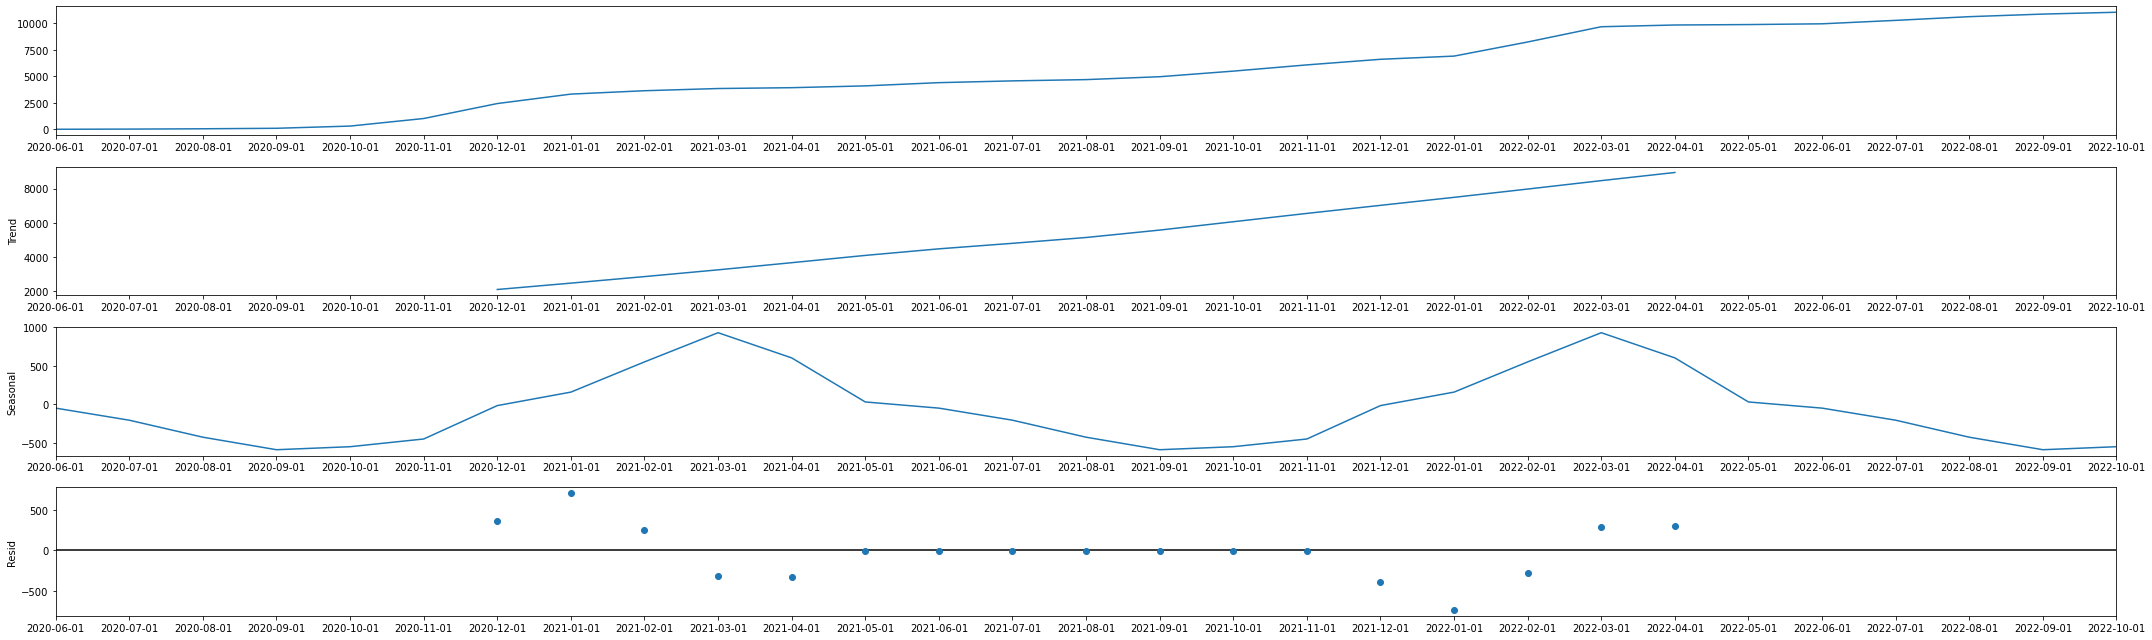

In [14]:
# c_df = create_data_county_state(re_df, 'Orange County', 'California')
c_df = create_data_county_state(re_df, 'Albany County', 'Wyoming')
# bronx , new york 7, 2 lowest 
# Hamilton , newyork 7,1 lowest 
# Los Angeles, California, many diff points 
# Orange ,Califonia, 2 is lowest but much different graph than Los Angeles 
# --> differ by county but they all have seasonality 

check_sesaon(c_df,'county_m_case_mean',12)

### Microb
__each state has their seasonality__: 
for each state, use seasonality. since it has year/month seasonaliyt, we use month and year feature to indicate seasonality

### Covid 
- mean death and mean cases has it's own seasonality for each county

https://towardsdatascience.com/taking-seasonality-into-consideration-for-time-series-analysis-4e1f4fbb768f

__county_m_case_median__ also has year seasonality (but all counties are similar)

stationary vs non-stationary : looks like none stationary because each year has differnt value 

multiplicative vs additive : ? 

## Augmented Dickey-Fuller Test (ADF Test)
https://medium.com/swlh/seasonality-analysis-and-forecast-in-time-series-b8fbba820327

- to check stationary: we canot create a time series model unless our series is stationary
if not stationary, we have to make the sereis stationary

A stationary series is one in which the properties — mean, variance and covariance, do not vary with time.

The null(H0) and alternate hypothesis(H1) of this test are:

H0: The series has a unit root (value of a =1),the series is non-stationary.

H1: The series has no unit root, the series is stationary.

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
def adf_test(data):
  print('adf testing')
  test_res = adfuller(data['microbusiness_density_x'],autolag = "AIC")
  # 'AIC': auto lag calculation
  # return: adf(test statistics), pvalue, usedlag, nobs(number of observations used for adf regression and calc of critical value )
  # critical values, 1,5,10 level, icvest: max info criterion of autolag is not None, resstre: dummyclasse 
  return test_res


  

p_val: 0.557 > 1% and 5% and 10% and p>0.05 -> we cannot reject H0-> __None stationary__
if the data is none stationary, we can fit __ARMIA__ and __Seasonal ARIMA (SARMIMA)__

# Feature Engineering 

# Feature Encoding 

In [20]:
# unneccesary: row_id, cfips, first_day_of_month, 'pct_bb_2017', 'pct_bb_2018',
#        'pct_bb_2019', 'pct_bb_2020', 'pct_bb_2021', 'pct_college_2017',
#        'pct_college_2018', 'pct_college_2019', 'pct_college_2020',
#        'pct_college_2021', 'pct_foreign_born_2017', 'pct_foreign_born_2018',
#        'pct_foreign_born_2019', 'pct_foreign_born_2020',
#        'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
#        'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
#        'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
#        'median_hh_inc_2020', 'median_hh_inc_2021','cases', 'deaths', 'year', 'month', 'day',

# categorical variables (nominal: no numeric realationship): county, state 
# oridnal: year, 


In [155]:
# onehot encoder for county and state (nominal)
df_sc = pd.get_dummies(df_sc, columns = ['county', 'state'])
df_sc

,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,county_Los Angeles County,state_California
7878,2019-08-01,14.297710,2019,8,1,82.1,20.7,34.2,4.7,64251.0,NaN,NaN,NaN,NaN,NaN,1,1
7879,2019-09-01,14.329043,2019,9,1,82.1,20.7,34.2,4.7,64251.0,14.297710,NaN,NaN,NaN,NaN,1,1
7880,2019-10-01,14.403519,2019,10,1,82.1,20.7,34.2,4.7,64251.0,14.329043,NaN,NaN,NaN,NaN,1,1
7881,2019-11-01,14.570203,2019,11,1,82.1,20.7,34.2,4.7,64251.0,14.403519,NaN,NaN,NaN,NaN,1,1
7882,2019-12-01,14.557307,2019,12,1,82.1,20.7,34.2,4.7,64251.0,14.570203,NaN,NaN,NaN,NaN,1,1
7883,2020-01-01,14.545367,2020,1,1,84.3,21.2,34.0,4.7,68044.0,14.557307,NaN,NaN,NaN,NaN,1,1
7884,2020-02-01,14.405687,2020,2,1,84.3,21.2,34.0,4.7,68044.0,14.545367,1.000000e+00,1.0,0.000000,0.0,1,1
7885,2020-03-01,14.480399,2020,3,1,84.3,21.2,34.0,4.7,68044.0,14.405687,1.000000e+00,1.0,0.000000,0.0,1,1
7886,2020-04-01,14.785244,2020,4,1,84.3,21.2,34.0,4.7,68044.0,14.480399,5.209355e+02,94.0,8.645161,1.0,1,1
7887,2020-05-01,14.872819,2020,5,1,84.3,21.2,34.0,4.7,68044.0,14.785244,1.207683e+04,10675.0,493.366667,428.5,1,1


In [156]:
df_sc = df_sc.dropna(axis = 0)
print(len(df_sc))

33


# Time realated features Encoding 

- https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

In [30]:
from sklego.preprocessing import RepeatingBasisFunction

In [157]:
df_sc.dtypes

first_day_of_month            object
microbusiness_density_x      float64
m_year                         int64
m_month                        int64
m_day                          int64
p1_y_bb                      float64
p1_y_college                 float64
p1_y_foreign_born            float64
p1_y_it_workers              float64
p1_y_median_hh_inc           float64
p1_m_mcrob_density           float64
county_m_case_mean           float64
county_m_case_median         float64
county_m_deaths_mean         float64
county_m_deaths_median       float64
county_Los Angeles County      uint8
state_California               uint8
dtype: object

In [158]:
df_sc['first_day_of_month']= pd.to_datetime(df_sc['first_day_of_month'])
df_sc = df_sc.reset_index(drop=True)

In [159]:
df_sc

,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,county_Los Angeles County,state_California
0,2020-02-01,14.405687,2020,2,1,84.3,21.2,34.0,4.7,68044.0,14.545367,1.000000e+00,1.0,0.000000,0.0,1,1
1,2020-03-01,14.480399,2020,3,1,84.3,21.2,34.0,4.7,68044.0,14.405687,1.000000e+00,1.0,0.000000,0.0,1,1
2,2020-04-01,14.785244,2020,4,1,84.3,21.2,34.0,4.7,68044.0,14.480399,5.209355e+02,94.0,8.645161,1.0,1,1
3,2020-05-01,14.872819,2020,5,1,84.3,21.2,34.0,4.7,68044.0,14.785244,1.207683e+04,10675.0,493.366667,428.5,1,1
4,2020-06-01,13.750809,2020,6,1,84.3,21.2,34.0,4.7,68044.0,14.872819,3.781648e+04,37303.0,1774.483871,1793.0,1,1
5,2020-07-01,13.877498,2020,7,1,84.3,21.2,34.0,4.7,68044.0,13.750809,7.650037e+04,74437.5,2925.200000,2942.5,1,1
6,2020-08-01,13.961786,2020,8,1,84.3,21.2,34.0,4.7,68044.0,13.877498,1.462598e+05,147468.0,3972.096774,3988.0,1,1
7,2020-09-01,13.988928,2020,9,1,84.3,21.2,34.0,4.7,68044.0,13.961786,2.192332e+05,221950.0,5258.451613,5254.0,1,1
8,2020-10-01,14.090169,2020,10,1,84.3,21.2,34.0,4.7,68044.0,13.988928,2.564697e+05,255598.5,6247.266667,6288.0,1,1
9,2020-11-01,14.071574,2020,11,1,84.3,21.2,34.0,4.7,68044.0,14.090169,2.880195e+05,287222.0,6847.129032,6855.0,1,1


# time numberical encoding

In [160]:
range_of_dates = pd.date_range(start="2020-02-01",end="2022-10-01",freq = 'MS')
X = pd.DataFrame(index=range_of_dates)
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

In [161]:
rbf = RepeatingBasisFunction(n_periods=1,column="day_of_year",input_range=(1,12),remainder="drop")
#print(rbf)
rbf.fit(X)
X_3 = pd.DataFrame(index=X.index,data=rbf.transform(X))

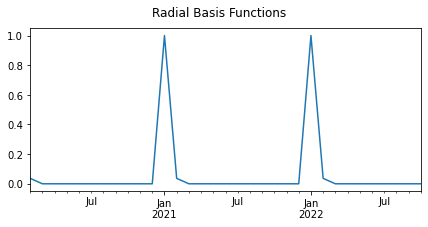

In [162]:
X_3.plot(subplots=True, figsize=(7, 3),sharex=True, title="Radial Basis Functions",legend=False);

In [163]:
# Create a new column with index values
X_3['index_column'] = X_3.index
X_3=X_3.reset_index()


In [164]:
X_3 = X_3.drop(columns = ['index_column'])
X_3 = X_3.rename(columns ={'index':'first_day_of_month',0:'first_day_of_month_fe'})
X_3.head()

,first_day_of_month,first_day_of_month_fe
0,2020-02-01,3.667041e-02
1,2020-03-01,2.411600e-09
2,2020-04-01,1.069183e-23
3,2020-05-01,3.720076e-44
4,2020-06-01,4.394446e-72


In [41]:
# join trainData and X_3 on first day of month
df_sc = pd.merge(df_sc,X_3,how = 'left',on = 'first_day_of_month')

# process categorical features 

In [47]:
# onehot encoder
from sklearn.preprocessing import OneHotEncoder


In [50]:
# f_train[f_train.isna().any(axis=1)]
# f_train = f_train.dropna()

In [166]:
unncess_cols = df_sc[['first_day_of_month','m_year','m_month','m_day']]

In [167]:
unncess_cols

,first_day_of_month,m_year,m_month,m_day
0,2020-02-01,2020,2,1
1,2020-03-01,2020,3,1
2,2020-04-01,2020,4,1
3,2020-05-01,2020,5,1
4,2020-06-01,2020,6,1
5,2020-07-01,2020,7,1
6,2020-08-01,2020,8,1
7,2020-09-01,2020,9,1
8,2020-10-01,2020,10,1
9,2020-11-01,2020,11,1


# one hot encoding for county and state

In [169]:
df_sc.head()

,first_day_of_month,microbusiness_density_x,m_year,m_month,m_day,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,county_Los Angeles County,state_California,first_day_of_month_fe
0,2020-02-01,14.405687,2020,2,1,84.3,21.2,34.0,4.7,68044.0,14.545367,1.000000,1.0,0.000000,0.0,1,1,3.667041e-02
1,2020-03-01,14.480399,2020,3,1,84.3,21.2,34.0,4.7,68044.0,14.405687,1.000000,1.0,0.000000,0.0,1,1,2.411600e-09
2,2020-04-01,14.785244,2020,4,1,84.3,21.2,34.0,4.7,68044.0,14.480399,520.935484,94.0,8.645161,1.0,1,1,1.069183e-23
3,2020-05-01,14.872819,2020,5,1,84.3,21.2,34.0,4.7,68044.0,14.785244,12076.833333,10675.0,493.366667,428.5,1,1,3.720076e-44
4,2020-06-01,13.750809,2020,6,1,84.3,21.2,34.0,4.7,68044.0,14.872819,37816.483871,37303.0,1774.483871,1793.0,1,1,4.394446e-72


# Numeric Featuer Normalization

In [56]:
from sklearn import preprocessing


In [170]:
numerical_cols = ['p1_y_bb', 'p1_y_college', 'p1_y_foreign_born', 'p1_y_it_workers', 'p1_y_median_hh_inc', 'p1_m_mcrob_density', 'county_m_case_mean', 'county_m_case_median', 'county_m_deaths_mean', 'county_m_deaths_median', 'first_day_of_month_fe']
label_cols = ["microbusiness_density_x"]
unness_cols = ['first_day_of_month','m_year','m_month','m_day']
categorical_cols = set(df_sc.columns) - set(numerical_cols)-set(label_cols)-set(unness_cols)
print(len(categorical_cols))



2


In [171]:
cat_df = df_sc[categorical_cols]

In [172]:
num_cols_df  = df_sc[numerical_cols]
col_names_num = num_cols_df.columns

In [173]:
label_df = df_sc["microbusiness_density_x"]

In [183]:
label_df

0     14.405687
1     14.480399
2     14.785244
3     14.872819
4     13.750809
5     13.877498
6     13.961786
7     13.988928
8     14.090169
9     14.071574
10    14.098359
11    14.077065
12    13.787151
13    13.937441
14    14.037723
15    14.041867
16    14.108413
17    14.133327
18    14.224660
19    14.154085
20    14.194254
21    14.336879
22    14.436436
23    14.453551
24    14.469463
25    14.544761
26    14.532945
27    14.415038
28    14.468369
29    14.663240
30    14.650445
31    14.627309
32    14.668964
Name: microbusiness_density_x, dtype: float64

In [174]:
x = num_cols_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled,columns = col_names_num)

In [175]:
df_scaled

,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,0.000000,0.000000,1.0,1.0,0.000000,0.708156,0.000000,0.000000,0.000000,0.000000,3.667041e-02
1,0.000000,0.000000,1.0,1.0,0.000000,0.583665,0.000000,0.000000,0.000000,0.000000,2.411600e-09
2,0.000000,0.000000,1.0,1.0,0.000000,0.650253,0.000151,0.000027,0.000259,0.000030,1.069183e-23
3,0.000000,0.000000,1.0,1.0,0.000000,0.921948,0.003515,0.003105,0.014768,0.012814,3.720076e-44
4,0.000000,0.000000,1.0,1.0,0.000000,1.000000,0.011008,0.010852,0.053114,0.053619,4.394446e-72
5,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.022268,0.021655,0.087558,0.087995,1.116588e-105
6,0.000000,0.000000,1.0,1.0,0.000000,0.112913,0.042574,0.042902,0.118893,0.119260,3.514398e-147
7,0.000000,0.000000,1.0,1.0,0.000000,0.188035,0.063816,0.064571,0.157397,0.157120,1.397481e-195
8,0.000000,0.000000,1.0,1.0,0.000000,0.212225,0.074655,0.074360,0.186994,0.188041,5.468805e-249
9,0.000000,0.000000,1.0,1.0,0.000000,0.302457,0.083839,0.083560,0.204949,0.204997,5.794195e-311


In [177]:
final  = pd.concat([cat_df,df_scaled],axis =1)
#final = pd.concat([final,unness_cols],axis = 1)

In [178]:
final

,state_California,county_Los Angeles County,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.708156,0.000000,0.000000,0.000000,0.000000,3.667041e-02
1,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.583665,0.000000,0.000000,0.000000,0.000000,2.411600e-09
2,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.650253,0.000151,0.000027,0.000259,0.000030,1.069183e-23
3,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.921948,0.003515,0.003105,0.014768,0.012814,3.720076e-44
4,1,1,0.000000,0.000000,1.0,1.0,0.000000,1.000000,0.011008,0.010852,0.053114,0.053619,4.394446e-72
5,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.022268,0.021655,0.087558,0.087995,1.116588e-105
6,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.112913,0.042574,0.042902,0.118893,0.119260,3.514398e-147
7,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.188035,0.063816,0.064571,0.157397,0.157120,1.397481e-195
8,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.212225,0.074655,0.074360,0.186994,0.188041,5.468805e-249
9,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.302457,0.083839,0.083560,0.204949,0.204997,5.794195e-311


In [74]:
# final = final.dropna()


In [179]:
final.dtypes

state_California               uint8
county_Los Angeles County      uint8
p1_y_bb                      float64
p1_y_college                 float64
p1_y_foreign_born            float64
p1_y_it_workers              float64
p1_y_median_hh_inc           float64
p1_m_mcrob_density           float64
county_m_case_mean           float64
county_m_case_median         float64
county_m_deaths_mean         float64
county_m_deaths_median       float64
first_day_of_month_fe        float64
dtype: object

In [182]:
final.head()

,state_California,county_Los Angeles County,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe
0,1,1,0.0,0.0,1.0,1.0,0.0,0.708156,0.000000,0.000000,0.000000,0.000000,3.667041e-02
1,1,1,0.0,0.0,1.0,1.0,0.0,0.583665,0.000000,0.000000,0.000000,0.000000,2.411600e-09
2,1,1,0.0,0.0,1.0,1.0,0.0,0.650253,0.000151,0.000027,0.000259,0.000030,1.069183e-23
3,1,1,0.0,0.0,1.0,1.0,0.0,0.921948,0.003515,0.003105,0.014768,0.012814,3.720076e-44
4,1,1,0.0,0.0,1.0,1.0,0.0,1.000000,0.011008,0.010852,0.053114,0.053619,4.394446e-72


# Model Fitting 
- since their seasonality is strong, we may not need complicated model: try simple models such as linear regression,lasso, ridge regresson, svm, polynomial, 
- then try tree methods 
- we won't need any complicated deep learning model for this problem 

In [82]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [190]:
final['y_lable'] = label_df

In [200]:
final_train = final[:30]

In [205]:
final_test = final[30:]

In [201]:
final_train

,state_California,county_Los Angeles County,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe,y_lable
0,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.708156,0.000000,0.000000,0.000000,0.000000,3.667041e-02,14.405687
1,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.583665,0.000000,0.000000,0.000000,0.000000,2.411600e-09,14.480399
2,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.650253,0.000151,0.000027,0.000259,0.000030,1.069183e-23,14.785244
3,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.921948,0.003515,0.003105,0.014768,0.012814,3.720076e-44,14.872819
4,1,1,0.000000,0.000000,1.0,1.0,0.000000,1.000000,0.011008,0.010852,0.053114,0.053619,4.394446e-72,13.750809
5,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.022268,0.021655,0.087558,0.087995,1.116588e-105,13.877498
6,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.112913,0.042574,0.042902,0.118893,0.119260,3.514398e-147,13.961786
7,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.188035,0.063816,0.064571,0.157397,0.157120,1.397481e-195,13.988928
8,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.212225,0.074655,0.074360,0.186994,0.188041,5.468805e-249,14.090169
9,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.302457,0.083839,0.083560,0.204949,0.204997,5.794195e-311,14.071574


# Exponentaial smoothing (double, or tripple)

In [86]:
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [222]:
fit1 = Holt(final_train['y_lable'],damped_trend = True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2
)
fcast1 = fit1.forecast(3).rename("Holt's linear trend")

In [223]:
fcast1

30    14.648436
31    14.668830
32    14.685145
Name: Holt's linear trend, dtype: float64

In [224]:
final_test['y_lable']

30    14.650445
31    14.627309
32    14.668964
Name: y_lable, dtype: float64

In [234]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [236]:
final_train_data = final[:30]
final_test_data = final[30:]


,state_California,county_Los Angeles County,p1_y_bb,p1_y_college,p1_y_foreign_born,p1_y_it_workers,p1_y_median_hh_inc,p1_m_mcrob_density,county_m_case_mean,county_m_case_median,county_m_deaths_mean,county_m_deaths_median,first_day_of_month_fe,y_lable
0,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.708156,0.000000,0.000000,0.000000,0.000000,3.667041e-02,14.405687
1,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.583665,0.000000,0.000000,0.000000,0.000000,2.411600e-09,14.480399
2,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.650253,0.000151,0.000027,0.000259,0.000030,1.069183e-23,14.785244
3,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.921948,0.003515,0.003105,0.014768,0.012814,3.720076e-44,14.872819
4,1,1,0.000000,0.000000,1.0,1.0,0.000000,1.000000,0.011008,0.010852,0.053114,0.053619,4.394446e-72,13.750809
5,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.022268,0.021655,0.087558,0.087995,1.116588e-105,13.877498
6,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.112913,0.042574,0.042902,0.118893,0.119260,3.514398e-147,13.961786
7,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.188035,0.063816,0.064571,0.157397,0.157120,1.397481e-195,13.988928
8,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.212225,0.074655,0.074360,0.186994,0.188041,5.468805e-249,14.090169
9,1,1,0.000000,0.000000,1.0,1.0,0.000000,0.302457,0.083839,0.083560,0.204949,0.204997,5.794195e-311,14.071574


In [239]:
train_y = final_train_data['y_lable']
train_X = final_train_data.drop(columns = ['y_lable'])

In [244]:
test_y = final_test_data['y_lable']
test_X = final_test_data.drop(columns = ['y_lable'])

In [245]:
test_y

30    14.650445
31    14.627309
32    14.668964
Name: y_lable, dtype: float64

In [242]:
print(len(train_y))

30


In [259]:
#https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56
mod = SARIMAX(train_y, 
 exog=train_X
 ,order=(0,1,1),
 enforce_invertibility=False, enforce_stationarity=False)


In [260]:
result = mod.fit()

In [261]:
predictions = result.predict(start = 30, end = 30+3-1,exog =test_X )

In [262]:
predictions

30    14.672957
31    14.636185
32    14.602009
Name: predicted_mean, dtype: float64